In [ ]:
!git clone --quiet https://github.com/tensorflow/models.git tensorflow_models

In [ ]:
!pip install ipywidgets

!jupyter nbextension enable --py widgetsnbextension

In [ ]:
import collections
import os
import StringIO
import sys
import tarfile
import tempfile
import urllib

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

if tf.__version__ < '1.5.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.5.0 or newer!')

# Needed to show segmentation colormap labels
sys.path.append('/content/tensorflow_models/research/deeplab/utils')
import get_dataset_colormap

In [ ]:
# Check configuration and download the model

_TARBALL_NAME = 'deeplab_model.tar.gz'

config = config_widget.result

model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print 'downloading model to %s, this might take a while...' % download_path
urllib.urlretrieve(config.model_url, download_path)
print 'download completed!'

downloading model to /tmp/tmpmkwCm0/deeplab_model.tar.gz, this might take a while...
download completed!


In [ ]:
_FROZEN_GRAPH_NAME = 'frozen_inference_graph'


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
            
    def run(self, image):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map


In [ ]:
model = DeepLabModel(download_path)

## Helper methods

In [ ]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)


## Run on sample images

running deeplab on image image1.jpg...


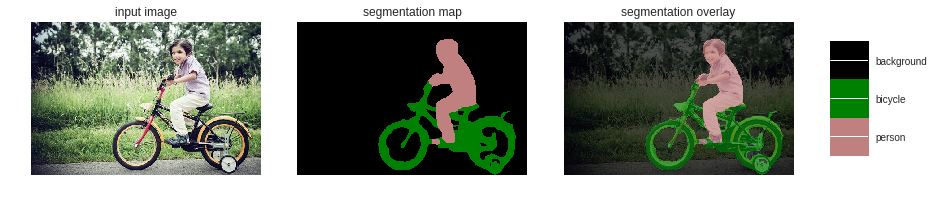

In [ ]:
# Note that we are using single scale inference in the demo for fast
# computation, so the results may slightly differ from the visualizations
# in README, which uses multi-scale and left-right flipped inputs.

IMAGE_DIR = '/content/tensorflow_models/research/deeplab/g3doc/img'

def run_demo_image(image_name):
    try:
        image_path = os.path.join(IMAGE_DIR, image_name)
        orignal_im = Image.open(image_path)
    except IOError:
        print 'Failed to read image from %s.' % image_path 
        return 
    print 'running deeplab on image %s...' % image_name
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)

_ = interact(run_demo_image, image_name=['image1.jpg', 'image2.jpg', 'image3.jpg'])

## Run on internet images

running deeplab on image http://1.citynews-forlitoday.stgy.ovh/~media/original-hi/37067688365190/protesta-cani-parco-urbano-municipale.jpg...


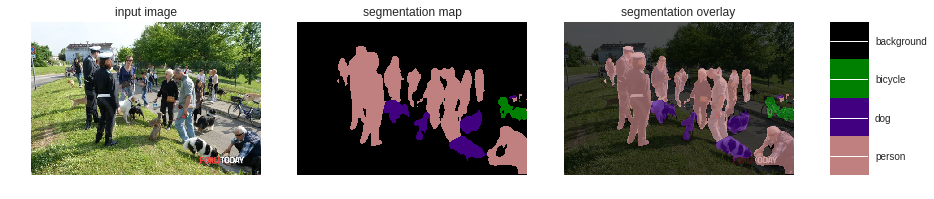

In [ ]:
def get_an_internet_image(url):
    if not url:
        return

    try:
        # Prefix with 'file://' for local file.
        if os.path.exists(url):
            url = 'file://' + url
        f = urllib.urlopen(url)
        jpeg_str = f.read()
    except IOError:
        print 'invalid url: ' + url
        return

    orignal_im = Image.open(StringIO.StringIO(jpeg_str))
    print 'running deeplab on image %s...' % url
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)

#_ = interact(get_an_internet_image, url='')
_ = get_an_internet_image(image_url)